# High-level Keras (CNTK) Example for Image Recognition on CIFAR-10


In this tutorial, we will examine the core functionality of the CNTK framework. In particular, we'll use the high-level Keras API to ingest data, train a model, and evaluate it on a test set. We will train our model using the CIFAR-10 dataset, developed by Alex Krizhevsky while a student at the University of Toronto, and available for download online [here](https://www.cs.toronto.edu/~kriz/cifar.html). A sample of each class is shown in the image below:


<img src="https://cntk.ai/jup/201/cifar-10.png" alt="Drawing" style="width: 500px;"/>


First, we'll import some core libraries and some helper functions. Also note that we are updating the `KERAS_BACKEND` variable to point to `CNTK` rather than `TensorFlow` or `Theano`. This is a convenient way of doing this interactively in a single session. If you'd like to make this your default, modify the `~/.keras/keras.json` file to always point to CNTK.

In [1]:
import os
import sys
import numpy as np
os.environ['KERAS_BACKEND'] = "cntk"
import keras as K
import cntk
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from common.params import *
from common.utils import *

Using CNTK backend


In [2]:
K.backend.set_image_data_format('channels_first')

Let's check the versions of our libraries and see if we're accessing the GPU from our CNTK distribution.

In [3]:
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", K.__version__)
print("Numpy: ", np.__version__)
print("CNTK: ", cntk.__version__)
print(K.backend.backend())
# Should be channels-first, otherwise slow
print(K.backend.image_data_format())
print("GPU: ", get_gpu_name())

OS:  linux
Python:  3.5.3 |Anaconda 4.4.0 (64-bit)| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Keras:  2.0.8
Numpy:  1.12.1
CNTK:  2.1
cntk
channels_first
GPU:  ['Tesla K80']


## Keras Sequential API
Keras has [two APIs](https://keras.io/models/about-keras-models/) for creating computational graphs: 1. Sequential API, and 2. Functional API. Here we examine the Sequential API. In this API, you specify your network architecture using a list of layers / activation functions. To simplify the construction, Keras also allows you to sequentially update your network architecture by using the `add` method:

In [4]:
def create_symbol():
    model = Sequential()
    
    model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(3, 32, 32)))
    model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(100, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(100, kernel_size=(3, 3), padding='same', activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model

### Compile and Run
Before you can train your network architecture, you need to configure the learning process. This is the process where you specify the loss function to optimize, and additional hyperparameters such as the optimization algorithm (SGD, Adam, RMSProp, etc.). 

In [5]:
def init_model(m):
    m.compile(
        loss = "categorical_crossentropy",
        optimizer = K.optimizers.SGD(LR, MOMENTUM),
        metrics = ['accuracy'])
    return m

## Train
Now we're ready to train our model. Let's first download our data using our helper functions:

In [6]:
%%time
# Data into format for library
x_train, x_test, y_train, y_test = cifar_for_library(channel_first=True, one_hot=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

Done.
Extracting files...
Done.
Preparing train set...
Preparing test set...
Done.
(50000, 3, 32, 32) (10000, 3, 32, 32) (50000, 10) (10000, 10)
float32 float32 int32 int32
CPU times: user 2.76 s, sys: 1.55 s, total: 4.31 s
Wall time: 13.6 s


## Create Computational Graph
Now let's create a computational graph where we can feed our data through:

In [7]:
%%time
# Load symbol
sym = create_symbol()

CPU times: user 196 ms, sys: 240 ms, total: 436 ms
Wall time: 439 ms


In [8]:
%%time
# Initialise model
model = init_model(sym)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 6.98 ms


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 32, 32)        1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 32, 32)        22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 16, 16)       45100     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 16, 16)       90100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 8, 8)         0         
__________

Finally, to train our model we use the `fit` method. This will compute our forward pass with some random initialization on an minibatch, compare against the true training data classes, and then compute the backward pass to update the parameters of our network. It will do this for a fixed integer set size of `epochs`, each of which is one complete pass through our data. 

In [10]:
%%time
# Train model
history = model.fit(x_train,
          y_train,
          batch_size=BATCHSIZE,
          epochs=EPOCHS,
          verbose=1)

Epoch 1/10
50000/50000 [==============================] - 21s - loss: 1.8466 - acc: 0.3244    
Epoch 2/10
50000/50000 [==============================] - 20s - loss: 1.3947 - acc: 0.4934    
Epoch 3/10
50000/50000 [==============================] - 20s - loss: 1.1781 - acc: 0.5792    
Epoch 4/10
50000/50000 [==============================] - 20s - loss: 1.0208 - acc: 0.6376    
Epoch 5/10
50000/50000 [==============================] - 20s - loss: 0.8968 - acc: 0.6820    
Epoch 6/10
50000/50000 [==============================] - 20s - loss: 0.8042 - acc: 0.7176    
Epoch 7/10
50000/50000 [==============================] - 20s - loss: 0.7244 - acc: 0.7455    
Epoch 8/10
50000/50000 [==============================] - 20s - loss: 0.6691 - acc: 0.7636    
Epoch 9/10
50000/50000 [==============================] - 20s - loss: 0.6073 - acc: 0.7854    
Epoch 10/10
50000/50000 [==============================] - 20s - loss: 0.5605 - acc: 0.8036    
CPU times: user 2min 51s, sys: 31.5 s, total: 3mi

In [11]:
%%time
y_guess = model.predict(x_test, batch_size=BATCHSIZE)
y_guess = np.argmax(y_guess, axis=-1)
y_truth = np.argmax(y_test, axis=-1)

CPU times: user 1.12 s, sys: 180 ms, total: 1.3 s
Wall time: 1.5 s


In [12]:
print("Accuracy: ", sum(y_guess == y_truth)/len(y_guess))

Accuracy:  0.7699


In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

### Visualize Learning Curve for Training Samples

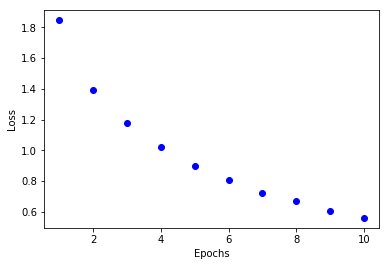

In [16]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss'] 
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo') 
plt.xlabel('Epochs') 
plt.ylabel('Loss')

plt.show()